# Imports and initializations

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import time

import voyageai

# Download the set of stopwords from NLTK
import nltk
nltk.download('punkt')

vo = voyageai.Client(api_key="pa-rhN-u_ArM1uxKF78V1JeB8-TJZM0lQlA60SIavXNHbg")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stlp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt

from scipy.spatial import distance
import scipy.stats as stats
import seaborn as sns

from sklearn.manifold import TSNE

# Loading the data

In [3]:
df = pd.read_csv("combined_data.csv")

In [4]:
df.head()

,owner_id,owner_username,shortcode,is_video,caption,comments,likes,created_at,location,imageUrl,multiple_images,username,followers,following
0,36063641,christendominique,C3_GS1ASeWI,False,I’m a brunch & Iced Coffee girlie☕️🍳 \n\nTop @...,268,16382,1.709327e+09,NaN,https://instagram.flba2-1.fna.fbcdn.net/v/t39....,True,christendominique,2144626.0,1021.0
1,36063641,christendominique,C38ivgNS3IX,True,😮‍💨Brow tips I really wish I would have know w...,138,9267,1.709241e+09,NaN,https://instagram.flba2-1.fna.fbcdn.net/v/t51....,False,christendominique,2144626.0,1021.0
2,36063641,christendominique,C35-Dd9SO1b,True,OMG I can’t believe it’s already been 1 yr sin...,1089,10100,1.709155e+09,NaN,https://instagram.flba2-1.fna.fbcdn.net/v/t51....,False,christendominique,2144626.0,1021.0
3,36063641,christendominique,C33TadDMisq,True,90’s Glam was Pam! \n\nMakeup \n@smashboxcosme...,271,6943,1.709065e+09,NaN,https://instagram.flba2-1.fna.fbcdn.net/v/t51....,False,christendominique,2144626.0,1021.0
4,36063641,christendominique,C3s-Cm1yCba,True,Chiseled & Sculptured 🏛️\n\n Contour @westmana...,145,17158,1.708718e+09,NaN,https://instagram.flba2-1.fna.fbcdn.net/v/t51....,False,christendominique,2144626.0,1021.0


In [5]:
df.shape

(11692, 14)

In [6]:
df.columns

Index(['owner_id', 'owner_username', 'shortcode', 'is_video', 'caption',
       'comments', 'likes', 'created_at', 'location', 'imageUrl',
       'multiple_images', 'username', 'followers', 'following'],
      dtype='object')

# 1. Text Cleaning: 
Process the caption column to remove any noise, such as HTML tags, emojis, special characters, and URLs. Normalize the text by converting it to lowercase, and optionally, remove stopwords to focus on meaningful words. Assume data is in a df column called caption

In [7]:
def clean_caption(caption):
    # Ensure caption is a string
    if not isinstance(caption, str):
        caption = str(caption)
    
    # # Convert to lowercase
    # caption = caption.lower()
    
    # # Remove URLs
    # caption = re.sub(r'http\S+|www\S+|https\S+', '', caption, flags=re.MULTILINE)
    
    # # Remove HTML tags
    # caption = re.sub(r'<.*?>', '', caption)
    
    # # Remove emojis and special characters
    # caption = re.sub(r'[\W_]+', ' ', caption)
    
    # # Tokenize the caption
    # words = word_tokenize(caption)
    
    # # Join words back into a single string
    # clean_caption = ' '.join(words)
    
    return clean_caption


In [8]:
# If you haven't filled NaN values previously, ensure you do it before applying the cleaning function:
df['caption'].fillna('', inplace=True)

# # Apply the cleaning function to your dataframe
# df['clean_caption'] = df['caption'].apply(clean_caption)

# Getting Embeddings

In [21]:
# Convert your dataframe caption column to a list and prepare them
texts = df['caption'].tolist()

In [22]:
# Recommended batch size from documentation and embeddings initialization
batch_size = 24

In [23]:
embeddings = []
progress_count = 0

# Process texts in batches
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    try:
        # First attempt: Request embeddings for the entire batch
        batch_embeddings = vo.embed(batch_texts, model="voyage-lite-02-instruct", input_type="document").embeddings
        embeddings.extend(batch_embeddings)
    except:
        # If the batch request fails, process each text individually
        batch_embeddings = []
        for text in batch_texts:
            try:
                # Request embedding for the current text individually
                embedding = vo.embed([text], model="voyage-lite-02-instruct", input_type="document").embeddings
                batch_embeddings.extend(embedding)
            except:
                # Append None for this text if an individual request also fails
                batch_embeddings.append(None)
        # Extend the embeddings list with results (successful or None for failures)
        embeddings.extend(batch_embeddings)

    # Optional: Wait for 0.1 seconds before proceeding to the next batch
    time.sleep(0.1)

    # Progress update
    progress = (progress_count / (len(texts) / batch_size)) * 100
    print(f"\rProgress: {progress:.3f}%", end='')
    progress_count += 1

print("\nDone!")


Progress: 99.966%
Done!


In [24]:
df["embeddings"] = embeddings

In [25]:
df.to_csv("combined_w_embeddings.csv")

# Clustering

In [26]:
embeddings_array = np.array(df['embeddings'].tolist())

In [27]:
ssd = []  # Sum of squared distances
silhouette_scores = []
K = range(2, 15)  # Let's test k from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_array)
    ssd.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center
    
    # Compute the silhouette score, only if k is greater than 1
    if k > 1:
        silhouette_scores.append(silhouette_score(embeddings_array, kmeans.labels_))


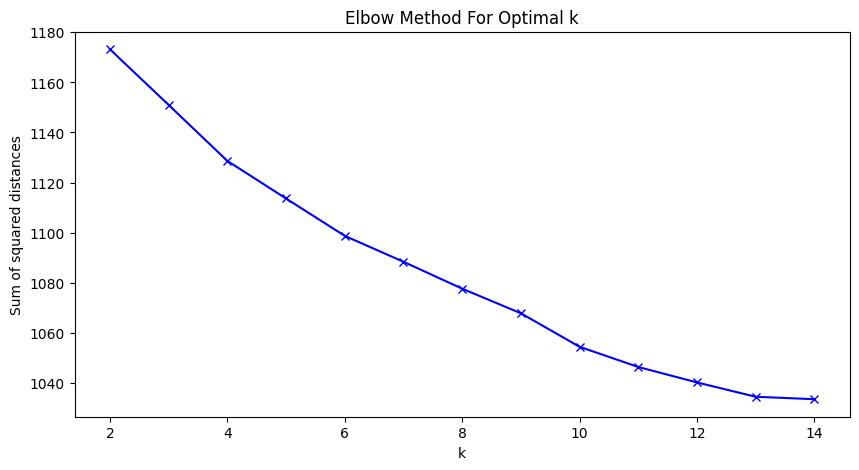

In [28]:
### 4. Plot the Elbow Method Results
plt.figure(figsize=(10, 5))
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

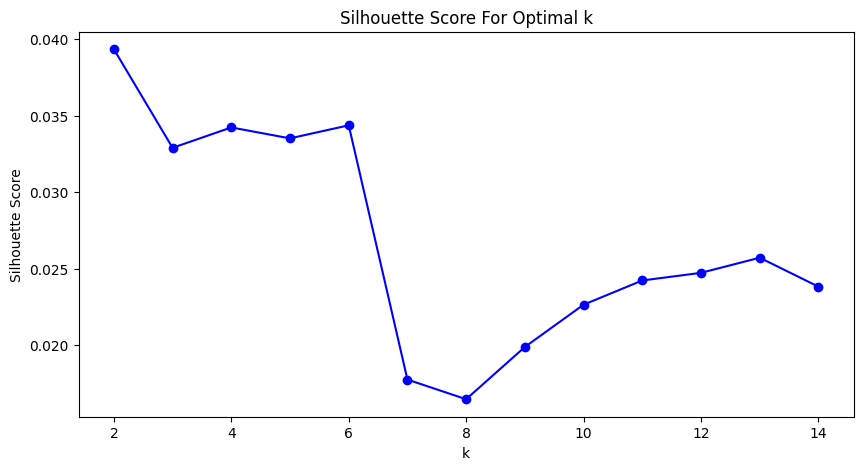

In [29]:
### Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

# Final Cluster

In [36]:
# Ideal cluster is k = 10
# Choose the number of clusters
k = 10  # Example value; adjust based on your analysis

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)

# Add cluster labels to your dataframe
df['cluster'] = clusters

# Analyze the clusters

In [37]:
print(df['cluster'].value_counts())

cluster
6    2055
3    1863
7    1814
2    1698
5    1214
0     884
4     807
1     568
8     453
9     336
Name: count, dtype: int64


In [38]:
# Compute centroids
centroids = kmeans.cluster_centers_

# For each cluster, find the text closest to the centroid
for i in range(k):
    cluster_embeddings = embeddings_array[df['cluster'] == i]
    centroid = centroids[i]
    distances = distance.cdist([centroid], cluster_embeddings, 'euclidean')[0]
    closest_index = np.argmin(distances)
    print(f"Cluster {i}: {df.iloc[closest_index]['caption']}")

Cluster 0: FINAL DE ANO ✨ 
Finalmente chegou o fim de ano desse ano que precisava acabar logo.
Não foi fácil pra ninguém, mas tá acabando.

Para terminar o ano com receitas gostosas e fotos lindas, me juntei com meu amigo @oiotavio (que tem um canal de receitas no IGTV só com coisa linda) e fizemos um mini-almoço de final de ano. Mini porque não é hora de aglomeração. Aproveite essa deixa para fazer pratos que sempre sonhou mas que eram inviáveis na ceia para dezenas de familiares famintos.

Todas as louças e utensílios nas fotos são da @nodacozinha a nova loja de objetos de cozinha do @oiotavio e do @avilapedro 🍴 

Cardápio:

Para beliscar na entrada:
Azeitonas marinadas e queijo de cabra.

Para comer:
Paleta de cordeiro assada lentamente com fatias de frutas cítricas e erva-doce.
Torta de bacalhau com massa folhada.
Salada de batata com cream cheese e cebolas caramelizadas.
Farofa crocante com castanha de cajú.

Para terminar:
Granita de Campari para comer/beber com Espumante - é dri

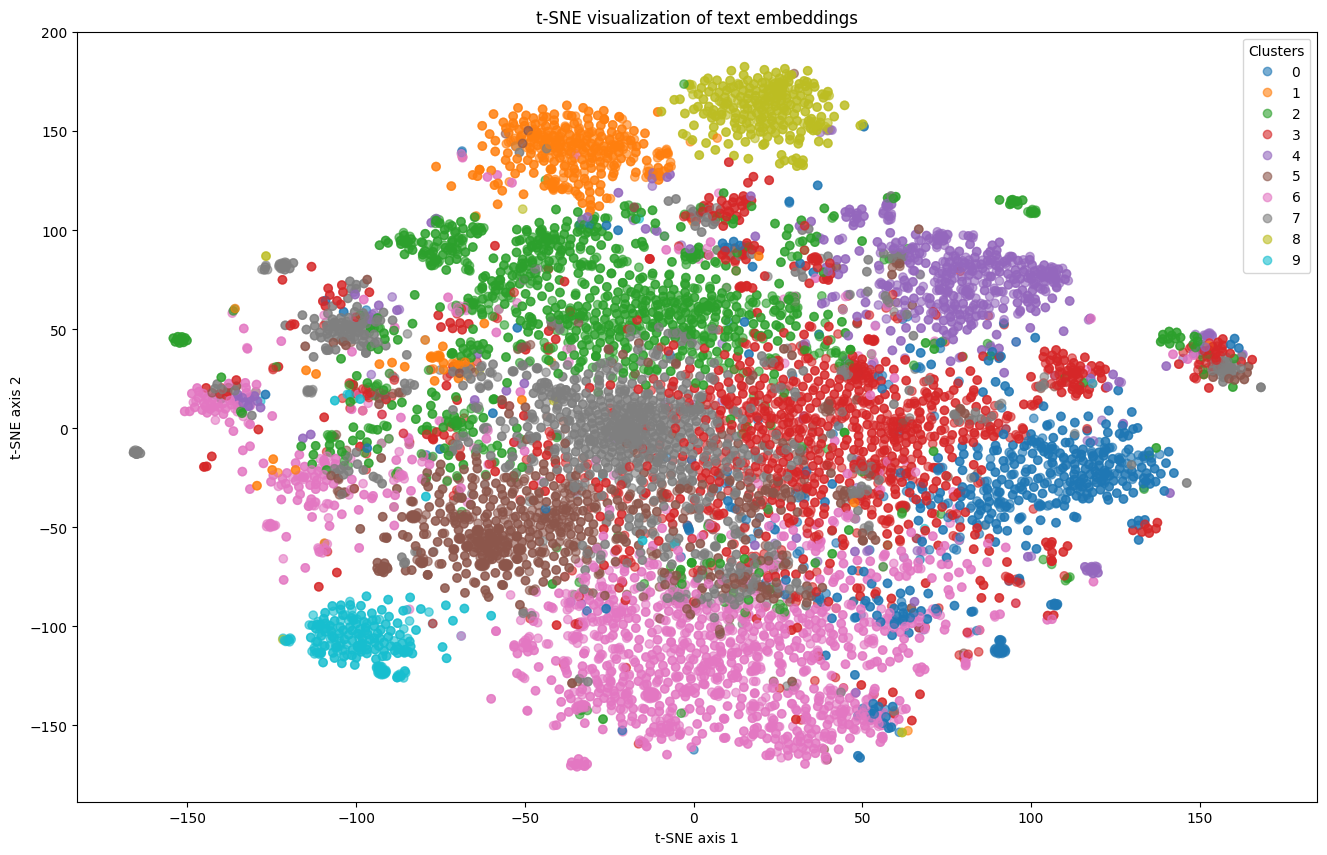

In [40]:
# Assuming you have your dataframe 'df' with a 'cluster' column indicating the cluster each point belongs to
# and embeddings_array which is a NumPy array of your embeddings

# Reduce the dimensionality of the embeddings to two dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(embeddings_array)

# Create a scatter plot
plt.figure(figsize=(16,10))

# Color each point based on its cluster label
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df['cluster'], cmap='tab10', alpha=0.6)

# Add a legend for the clusters
plt.legend(handles=scatter.legend_elements()[0], labels=set(df['cluster']), title="Clusters")

# Show the plot
plt.title('t-SNE visualization of text embeddings')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()

# Merging clusters based on PCA

In [41]:
# Let's merge clusters 7 and 3 into cluster '3'
df['cluster'] = df['cluster'].replace(7, 3)

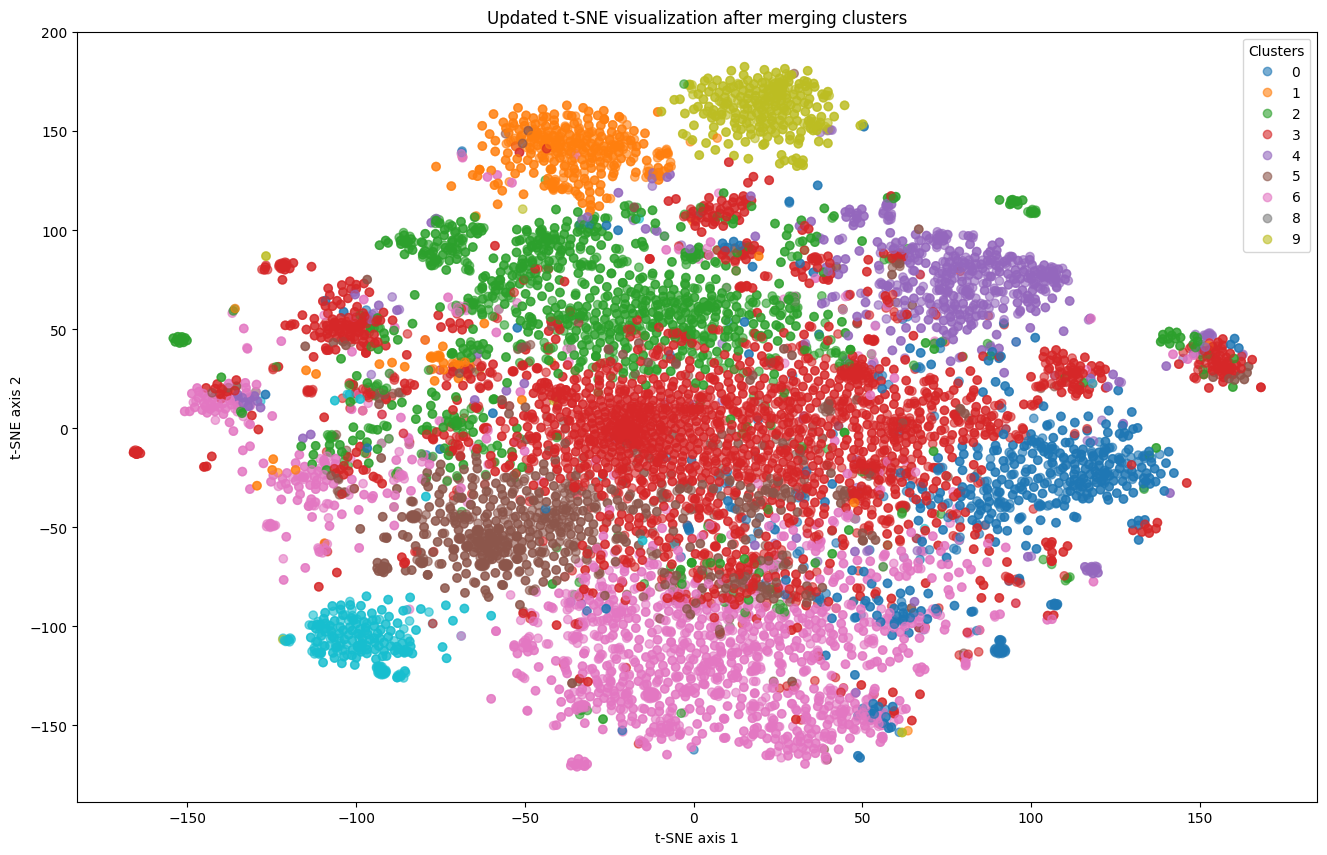

In [43]:
# Assuming you've done t-SNE or another dimensionality reduction and have a 2D representation:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df['cluster'], cmap='tab10', alpha=0.6)

# Add a legend for the clusters
plt.legend(handles=scatter.legend_elements()[0], labels=set(df['cluster']), title="Clusters")

plt.title('Updated t-SNE visualization after merging clusters')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()

# Analysis

In [46]:
# Convert 'likes' and 'comments' to numeric, coercing errors into NaN
df['likes'] = pd.to_numeric(df['likes'], errors='coerce')
df['comments'] = pd.to_numeric(df['comments'], errors='coerce')

# Now you can drop any rows with NaN if they do not make sense for your analysis
df1 = df.dropna(subset=['likes', 'comments'])

In [47]:
# Example: Calculate mean number of likes and comments, and count the number of posts per cluster
cluster_insights = df1.groupby('cluster').agg(
    posts=('likes', 'size'),            # Count the number of posts in each cluster
    mean_likes=('likes', 'mean'),       # Calculate the mean number of likes
    mean_comments=('comments', 'mean')  # Calculate the mean number of comments
)

print(cluster_insights)

         posts    mean_likes  mean_comments
cluster                                    
0          884  17844.633484     279.373303
1          568  26209.688380     305.654930
2         1698  27023.369847     438.494700
3         3677  49803.888768     626.477019
4          807   9423.374226     131.537794
5         1211  55465.563997     392.291495
6         2055   9437.290998     281.337713
8          453  36384.766004     445.099338
9          336  14902.586310      90.226190


# Statistical Analysis

## Descriptive

In [56]:
descriptive_stats = df1.groupby('cluster')[['likes', 'comments']].describe()
descriptive_stats

likes                                                              \
          count          mean            std   min    25%     50%       75%   
cluster                                                                       
0         884.0  17844.633484  108236.260766   9.0  571.0  2281.0   9404.00   
1         568.0  26209.688380   83223.765489   6.0  845.5  3825.0  18994.50   
2        1698.0  27023.369847  256934.103122   0.0  461.0  2040.0   7286.75   
3        3677.0  49803.888768  249776.466083   0.0  870.0  3222.0  16320.00   
4         807.0   9423.374226   64181.030247   0.0  326.0  1042.0   3641.00   
5        1211.0  55465.563997  489585.042925   0.0  291.0  1738.0   7977.50   
6        2055.0   9437.290998   42904.409896   0.0  579.0  1889.0   6265.00   
8         453.0  36384.766004  154254.998502   5.0  526.0  2730.0   7404.00   
9         336.0  14902.586310   64721.176459  44.0  732.0  1504.0   4188.75   

                    comments                                                   \
                max    count        mean          std  min   25%   50%    75%   
cluster                                                                         
0         2769000.0    884.0  279.373303  1164.586106  0.0  13.0  48.0  174.0   
1         1086396.0    568.0  305.654930  1019.144440  0.0  15.0  68.0  222.0   
2         8698871.0   1698.0  438.494700  2855.300636  0.0  11.0  39.0  118.0   
3         9100574.0   3677.0  626.477019  4340.610628  0.0  15.0  53.0  179.0   
4         1080114.0    807.0  131.537794   540.630703  0.0   8.0  27.0   90.0   
5        12685879.0   1211.0  392.291495  3989.911961  0.0   4.0  24.0   76.0   
6         1064263.0   2055.0  281.337713  4031.046810  0.0  10.0  33.0   96.5   
8         1361349.0    453.0  445.099338  1720.502939  0.0  13.0  59.0  200.0   
9          508651.0    336.0   90.226190   294.925737  0.0   2.0  13.0   43.5   

                   
              max  
cluster            
0         18068.0  
1         13936.0  
2         58758.0  
3         90183.0  
4         12375.0  
5        122771.0  
6        107244.0  
8         17322.0  
9          2815.0

## Inferential Statistics

In [63]:
# Perform an ANOVA test to determine if there are statistically significant differences
# in 'likes' between clusters
f_val_likes, p_val_likes = f_oneway(*(df1[df1['cluster'] == c]['likes'] for c in df1['cluster'].unique()))

# Do the same for 'comments'
f_val_comments, p_val_comments = f_oneway(*(df1[df1['cluster'] == c]['comments'] for c in df1['cluster'].unique()))


In [68]:
print(f_val_likes, p_val_likes)
print(f_val_comments, p_val_comments)

7.981134795854087 8.751349325247414e-11
3.4259878504444687 0.000607014923495661


In [65]:
# Post-hoc test for 'likes'
tukey_likes = pairwise_tukeyhsd(endog=df1['likes'], groups=df1['cluster'], alpha=0.05)

# Post-hoc test for 'comments'
tukey_comments = pairwise_tukeyhsd(endog=df1['comments'], groups=df1['cluster'], alpha=0.05)

c:\Users\stlp\anaconda3\envs\poc\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [70]:
print(tukey_likes)
print(tukey_comments)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     0      1   8365.0549 0.9993 -31439.6723  48169.7821  False
     0      2   9178.7364 0.9915   -21521.01  39878.4827  False
     0      3  31959.2553 0.0106   4231.8818  59686.6288   True
     0      4  -8421.2593 0.9985 -44459.2482  27616.7297  False
     0      5  37620.9305  0.011   4875.8959  70365.9651   True
     0      6  -8407.3425 0.9942 -38180.1227  21365.4377  False
     0      8  18540.1325 0.9178 -24230.1495  61310.4146  False
     0      9  -2942.0472    1.0 -50381.0758  44496.9815  False
     1      2    813.6815    1.0 -35065.1744  36692.5374  False
     1      3  23594.2004 0.4099  -9776.8217  56965.2225  False
     1      4 -16786.3142 0.9361 -57327.0902  23754.4619  False
     1      5  29255.8756 0.2778  -8387.9176  66899.6688  False
     1      6 -16772.3974 0.8638 -51861.

In [67]:
correlation_insights = df1.groupby('cluster')[['likes', 'comments']].corr().unstack().iloc[:,1]
correlation_insights

cluster
0    0.709535
1    0.751163
2    0.217422
3    0.197334
4    0.696112
5    0.349200
6    0.070751
8    0.933592
9    0.704991
Name: (likes, comments), dtype: float64

In [74]:
# Set a seed for reproducibility
np.random.seed(42)

# Print 5 random samples from each cluster
random_samples = df.groupby('cluster').apply(lambda x: x.sample(n=5 if len(x) > 5 else len(x)))

print(random_samples["caption"])

cluster       
0        851      I’m mentally preparing myself for cold blooded...
         5529     Challenge STARTS TODAY!!🌈🙌🏻YOU IN?🙋🏼‍♀️\n\nLet...
         8902     SUPPORT children in Congo today – please DONAT...
         10029    Throw me in any Jungle n Imma make that sh my ...
         11580    Send your best 🗡️\nSuch a fun & challenging th...
1        10726    Estáis de acuerdo? 😀\n•\n#Remake pero no tengo...
         10817    Merry Christmas everyone! This is actually my ...
         993      El ”Zorro orejas de murciélago” es una especie...
         10730              El día de llevar a los hijos al trabajo
         2022     si fuera el sol yo también te daría unos besos...
2        6093     Help me pick a outfit for Date Night❤️ @fashio...
         9164                               New #makeup #transition
         11208    Haven’t had lip filler since 2019 and I don’t ...
         2788     In my GLAM ERA. \nHere are four more Eras Tour...
         71       Happy #Internat

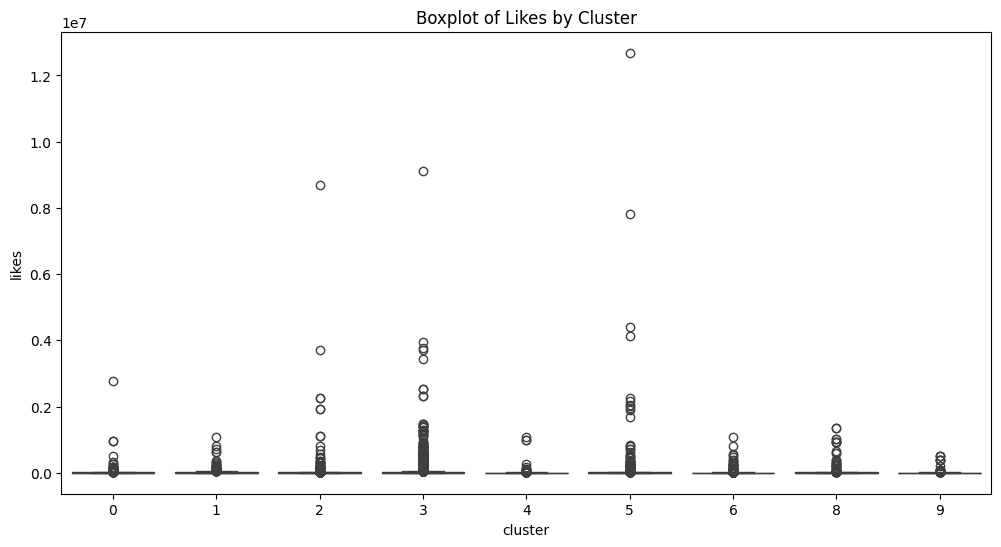

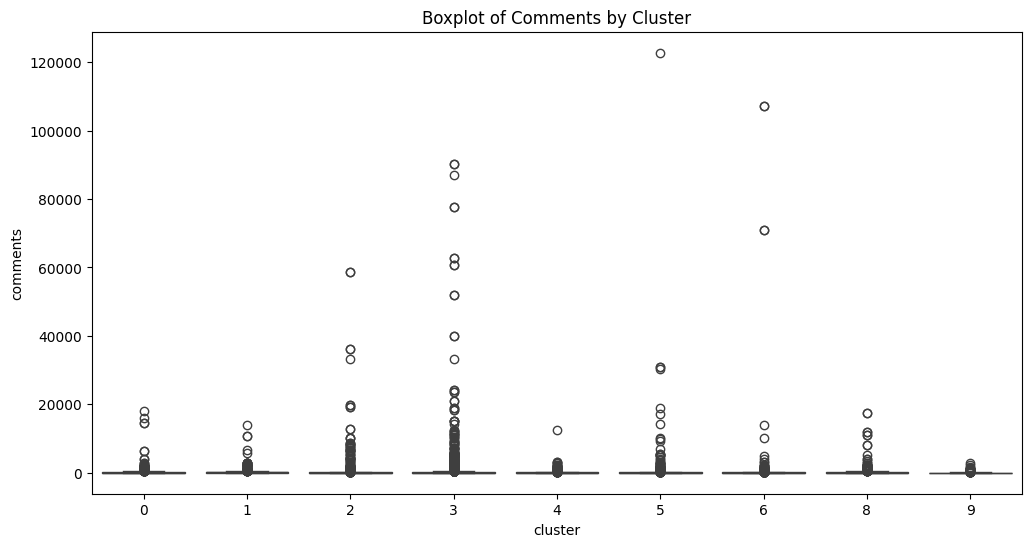

In [75]:
# Boxplot for likes
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='likes', data=df)
plt.title('Boxplot of Likes by Cluster')
plt.show()

# Boxplot for comments
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='comments', data=df)
plt.title('Boxplot of Comments by Cluster')
plt.show()

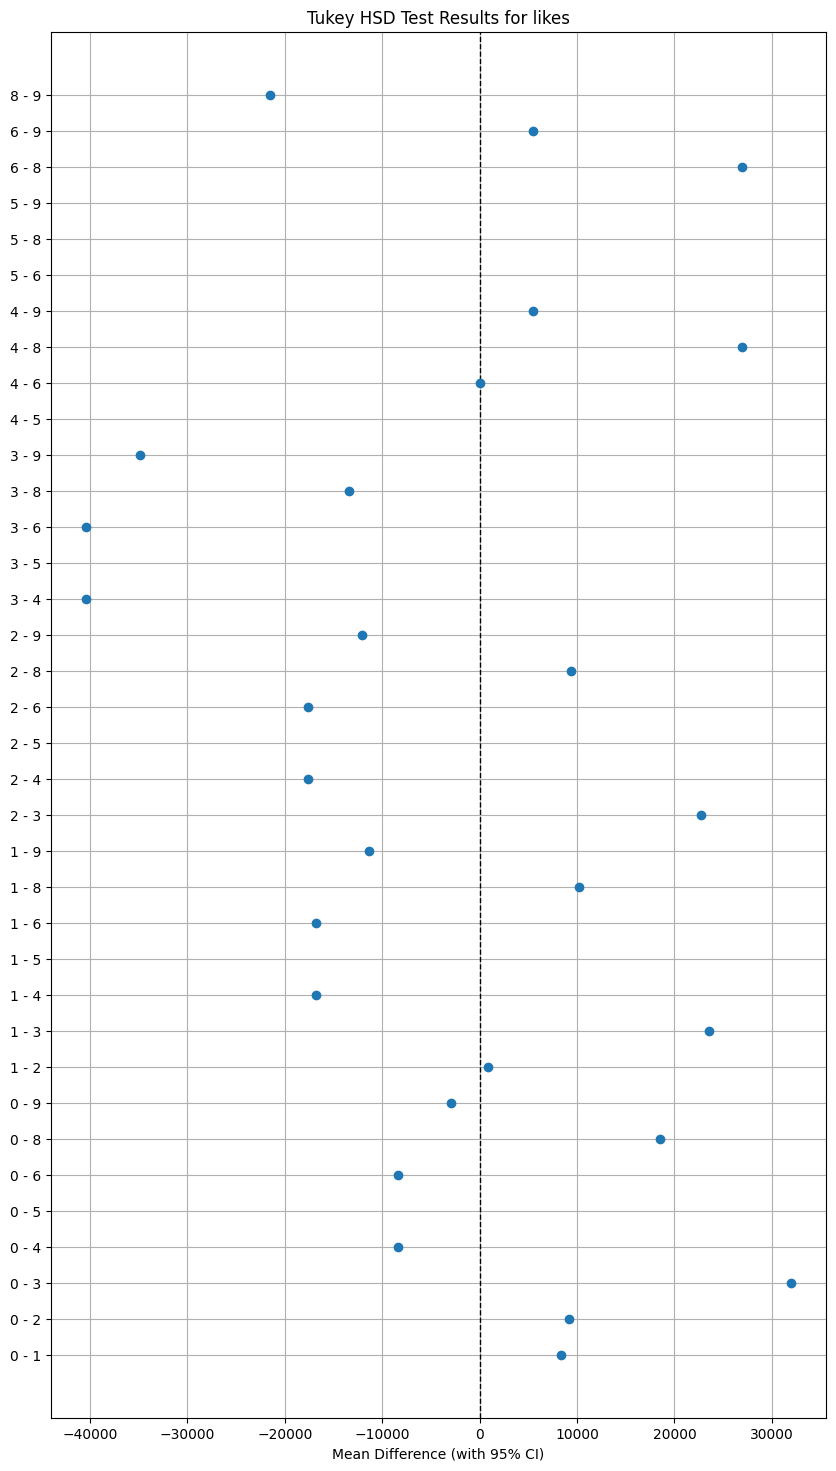

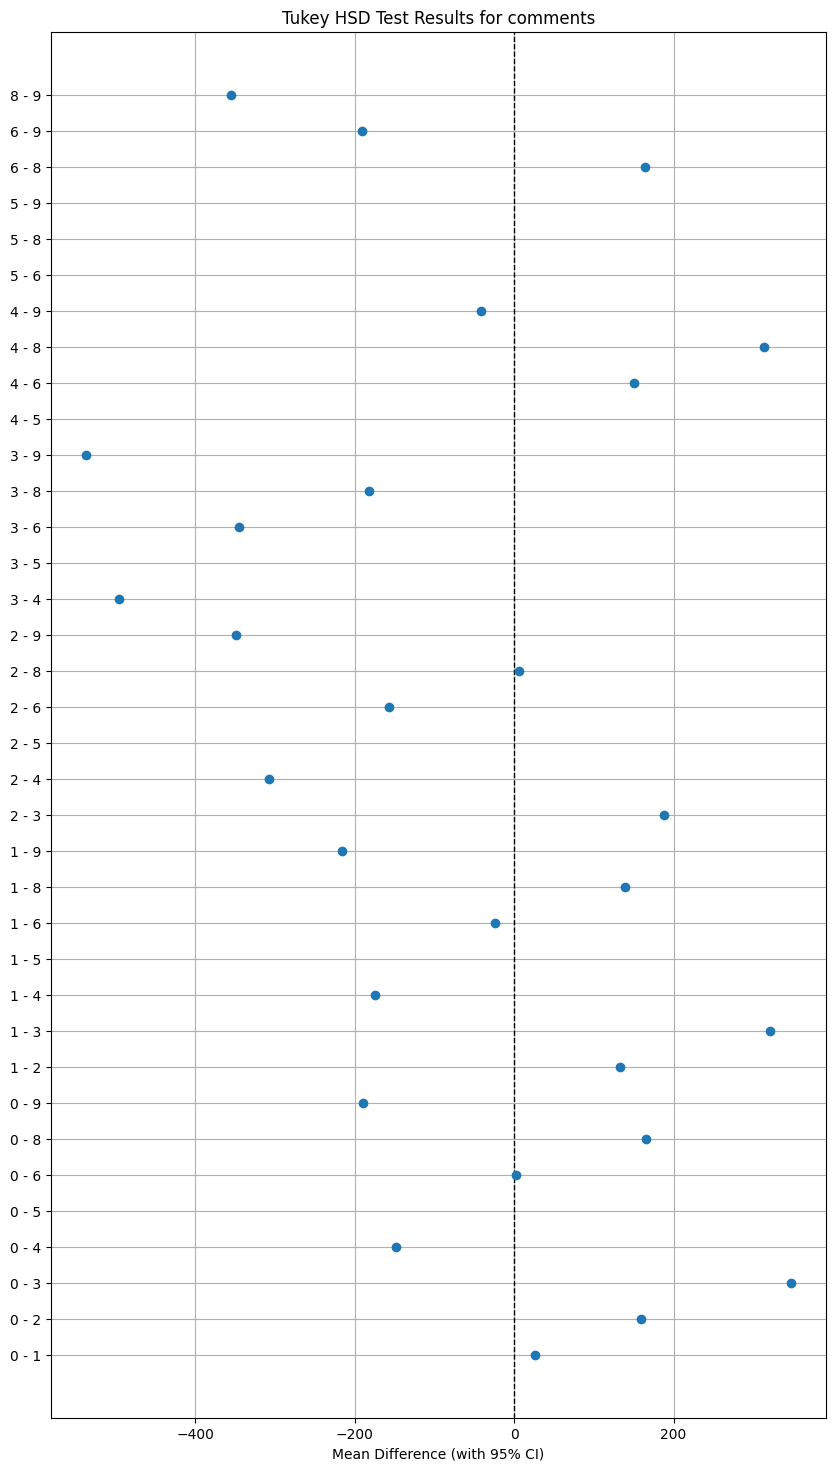

In [76]:
from statsmodels.stats.multicomp import MultiComparison

def plot_tukey_hsd(df, variable, group):
    # Perform Tukey HSD test
    mc = MultiComparison(df[variable], df[group])
    tukey_result = mc.tukeyhsd()

    # Convert the result to a DataFrame
    tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

    # Sort by meandiff
    tukey_df.sort_values('meandiff', inplace=True)

    # Plot the results
    plt.figure(figsize=(10, len(tukey_df)/2))
    plt.errorbar(x=tukey_df['meandiff'], y=tukey_df.index,
                 xerr=(tukey_df['upper'] - tukey_df['lower'])/2, fmt='o')
    plt.axvline(x=0, color='black', lw=1, linestyle='--')
    plt.yticks(tukey_df.index, ["{} - {}".format(row['group1'], row['group2']) for index, row in tukey_df.iterrows()])
    plt.title('Tukey HSD Test Results for {}'.format(variable))
    plt.xlabel('Mean Difference (with 95% CI)')
    plt.grid(True)
    plt.show()

# Plot Tukey HSD test results for likes
plot_tukey_hsd(df, 'likes', 'cluster')

# Plot Tukey HSD test results for comments
plot_tukey_hsd(df, 'comments', 'cluster')

In [86]:
# Set a seed for reproducibility
np.random.seed(4210)

# Print 5 random samples from each cluster
random_samples = df.groupby('cluster').apply(lambda x: x.sample(n=5 if len(x) > 5 else len(x)))

print(random_samples["caption"])

cluster       
0        440      Have you ever looked back at a time in your li...
         5502     Throw me in any Jungle n Imma make that sh my ...
         6487     For many, being a teenager is hard. #Bodyimage...
         9670     Slowing down has been essential in my wellness...
         9714     Are supplements necessary and WHICH ONES and W...
1        3402     Estuvimos viendo el primer capítulo de la mini...
         9371     Cruzar un paso de cebra en esta ciudad era un ...
         807      M A L A G A 💃🏽🫶🏼✨ gracias de nuevo @festivalma...
         3395     Somos buzos avanzados!!! Espera ADVANCED OPEN ...
         5713     🅲🅾🅽🅽🅴🅲🆃🅴🅳\n\nno me pierdo nada.. todo al día y...
2        6868     @gucci @sabatods ♥️ \n\nStay tuned for the rev...
         1400     Today is the final day of the campaign for my ...
         2361     Transform yourself into the enchanting Disney ...
         8009     🖤\n\nOutfit: @guess\nAccessories: @bijoubrigit...
         11525    Devon Cloud Sue